In [1]:
% matplotlib inline
from sensor_data_analysis_api import *

In [2]:
def read_dataframe_pca(rooms, signal):
    final_df = pd.DataFrame()
    for room in rooms:
        data_df = get_signal_dataframe(room = room, signals = [signal], mean_type="quarter_hour", use_weather_data=False)
        data_df = data_df[~data_df.time.dt.weekofyear.isin([1,52,53])]
        data_df["year_week"] = data_df.time.dt.year.astype(str) + "-" + data_df.time.dt.week.astype(str)
        data_df["week_time"] = data_df.time.dt.weekday_name + "-" + data_df.time.dt.time.astype(str)
        final_df = final_df.append(data_df.pivot(index=("year_week"), columns="week_time",
                                                 values=signal), ignore_index=True)

    day = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2, 'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday' : 6}
    final_df = final_df[sorted(final_df.columns, key=lambda x: day[x.split('-')[0]])].dropna()
    final_df.index= range(len(final_df))
    return final_df

In [3]:
rooms = ['Rm-2221', 'Rm-3126', 'Rm-2218', 'Rm-3122', 'Rm-3111','RM-1217', 'Rm-2226',
         'Rm-3118', 'RM-1231', 'Rm-2230','RM-1229', 'Rm-2232']
final_df_zt = read_dataframe_pca(rooms, 'Zone Temperature')
final_df_saf = read_dataframe_pca(rooms, "Supply Airflow")

Read file:  506_0_3001348.csv
Read file:  506_0_3003036.csv
Read file:  506_0_3001368.csv
Read file:  506_0_3003056.csv
Read file:  506_0_3003096.csv
Read file:  505_0_3001793.csv
Read file:  506_0_3001388.csv
Read file:  506_0_3003076.csv
Read file:  505_0_3001810.csv
Read file:  506_0_3001408.csv
Read file:  505_0_3001830.csv
Read file:  506_0_3001429.csv
Read file:  506_0_3001354.csv
Read file:  506_0_3003042.csv
Read file:  506_0_3001374.csv
Read file:  506_0_3003062.csv
Read file:  506_0_3003102.csv
Read file:  505_0_3001798.csv
Read file:  506_0_3001394.csv
Read file:  506_0_3003082.csv
Read file:  505_0_3001816.csv
Read file:  506_0_3001414.csv
Read file:  505_0_3001836.csv
Read file:  506_0_3001435.csv


## Number of PCA components

- Number of components Vs explained variance is plotted
- 95% of variance is explained with 11 components for zone temperature
- 95% of vairnace is explained with 24 components for supply airflow

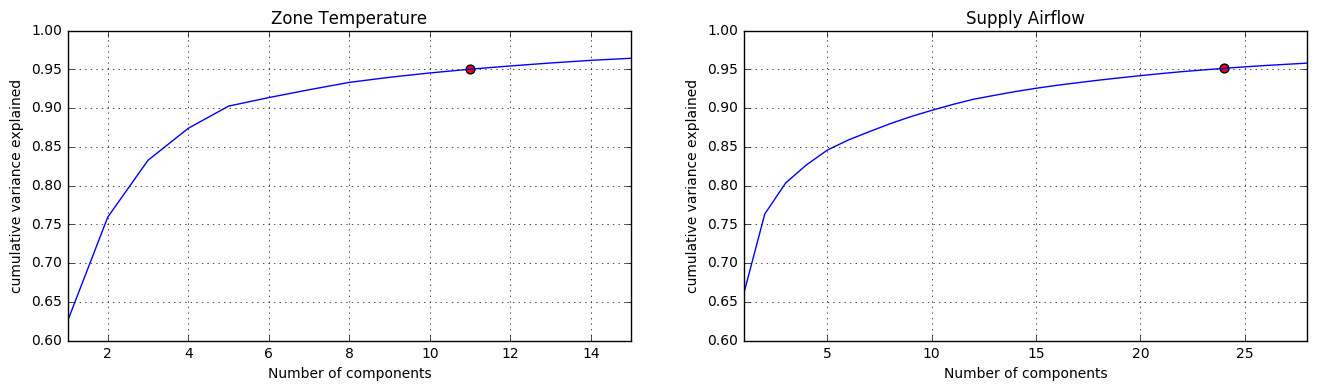

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

def plot_components_variance(df, ax, signal):
    n_components = len(df.columns)
    pca = PCA(n_components = n_components).fit(df)
    top_components = (np.cumsum(pca.explained_variance_ratio_) < 0.95).sum() + 5
    se = pd.Series(np.cumsum(pca.explained_variance_ratio_[:top_components]),
                   index=range(1, top_components + 1))
    se.plot(grid=True, title=signal, ax=ax)
    ax.set(xlabel='Number of components', ylabel='cumulative variance explained')
    x, y = se[se > 0.95].head(1).index[0], se[se > 0.95].head(1).iloc[0]
    ax.scatter(x=[x], y=[y], c="red", s=40)

plot_components_variance(final_df_zt, axes[0], 'Zone Temperature')
plot_components_variance(final_df_saf, axes[1], 'Supply Airflow')

In [41]:
pca = PCA(n_components = 3).fit(final_df_zt)


In [43]:
final_df_zt.head()

week_time,Monday-00:00:00,Monday-00:15:00,Monday-00:30:00,Monday-00:45:00,Monday-01:00:00,Monday-01:15:00,Monday-01:30:00,Monday-01:45:00,Monday-02:00:00,Monday-02:15:00,...,Sunday-21:30:00,Sunday-21:45:00,Sunday-22:00:00,Sunday-22:15:00,Sunday-22:30:00,Sunday-22:45:00,Sunday-23:00:00,Sunday-23:15:00,Sunday-23:30:00,Sunday-23:45:00
0,74.82,74.82,74.82,74.82,74.82,74.82,74.82,74.82,74.82,74.82,...,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80
1,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80,74.80,...,74.92,74.92,74.92,74.92,74.92,74.92,74.92,74.92,74.92,74.92
2,75.36,75.36,75.36,75.36,75.36,75.36,75.36,75.36,75.36,75.36,...,75.37,75.37,75.88,75.88,75.88,75.88,75.88,75.88,75.88,75.88
3,75.88,75.88,75.88,75.88,75.88,75.88,75.88,75.88,75.88,75.88,...,75.90,75.90,75.90,75.90,75.90,75.90,75.90,75.90,75.90,75.90
4,75.34,75.34,75.34,75.34,75.34,75.34,75.34,75.34,75.34,75.34,...,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00,75.00


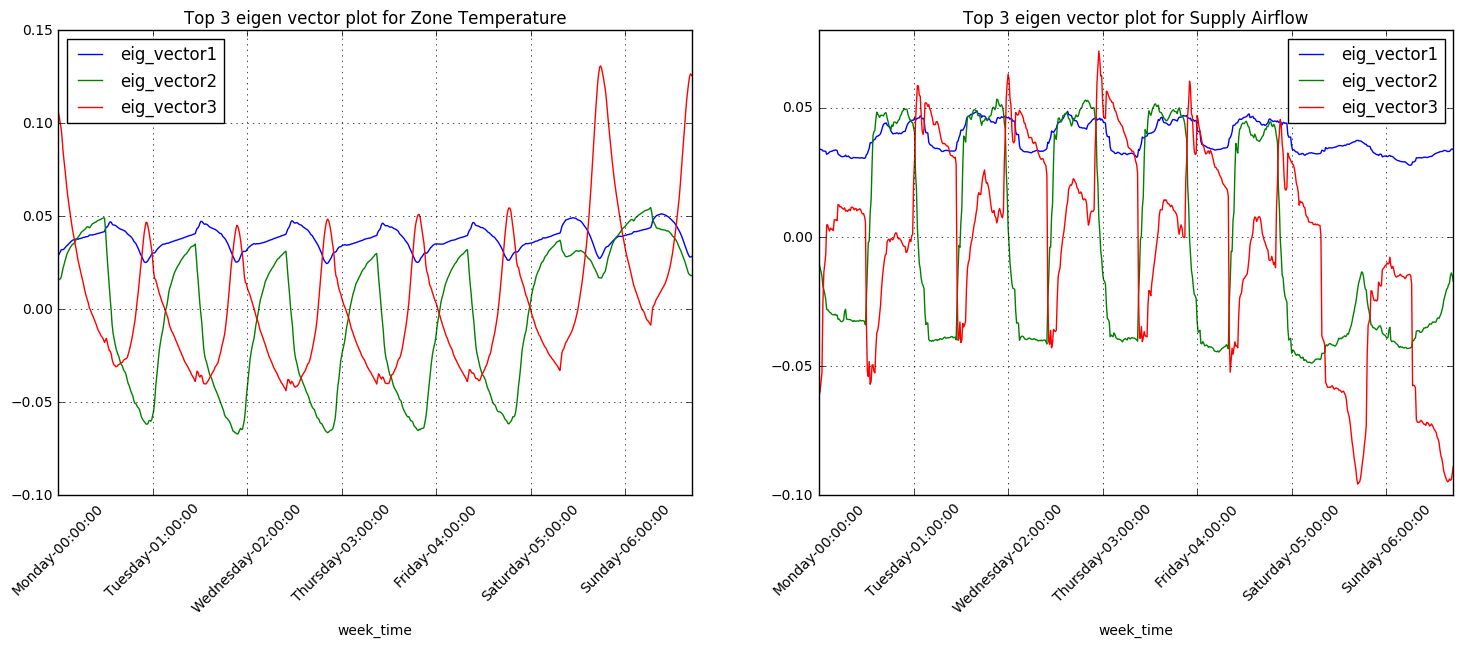

In [81]:
def plot_eigen_vectors(df, ax, signal, n_top=3):
    # calculate the covairnace matrix of the data
    cov_matrix = np.cov(df, rowvar=False)

    # find the eigen values are eigen vectors
    eig_values, eig_vectors = np.linalg.eig(cov_matrix)

    # Get the indices of top 3 eigen values
    eigen_val_index = pd.Series(eig_values).sort_values(ascending=False).head(n_top).index.tolist()
    pd.DataFrame(eig_vectors[:, eigen_val_index], index=final_df_zt.columns,
        columns=map(lambda x: "eig_vector" + str(x), range(1, n_top + 1))).plot(
        grid=True, rot=45, ax=ax, title='Top %d eigen vector plot for %s'%(n_top, signal))

fig, axes = plt.subplots(1,2, figsize=(18, 6))
plot_eigen_vectors(final_df_zt, axes[0], 'Zone Temperature')
plot_eigen_vectors(final_df_saf, axes[1], 'Supply Airflow')

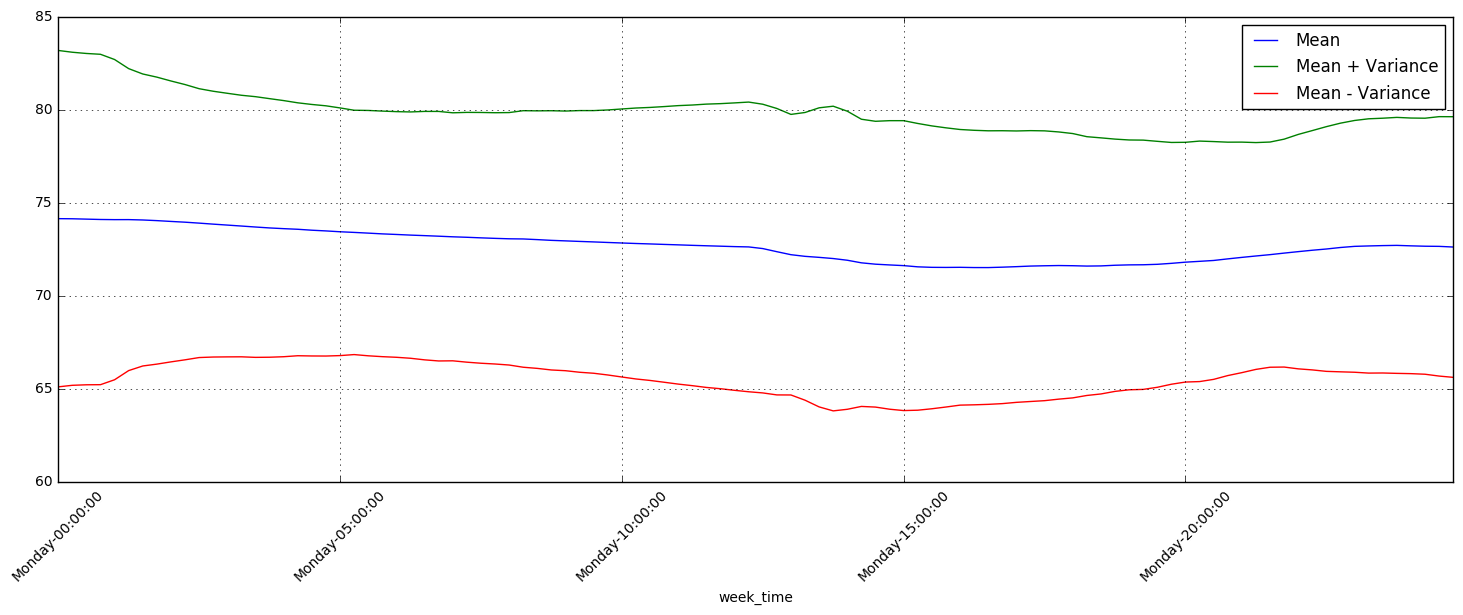

In [93]:
plot_df = pd.DataFrame([final_df_zt.mean(), final_df_zt.mean() + final_df_zt.var(), final_df_zt.mean() - final_df_zt.var()],
            index = ["Mean", "Mean + Variance", "Mean - Variance"]).T
plot_df.head(100).plot(grid=True, rot=45, figsize=(18, 6));